In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader, Subset
import torchvision.models as models
from torchvision import datasets, transforms
import torch.optim as optim
from tqdm import tqdm

ModuleNotFoundError: No module named 'torch'

In [2]:
data_path = "/Users/firmansyahsundana/Documents/tesis/data"

# Data Loader Setup

- 64×64
- 128×128
- 160×160
- 192×192
- 224×224
- 256×256
- 320×320

## 64x64

In [4]:
from data_setup import create_dataloader

# Define transformations, including resizing, converting to tensor, and normalization
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64 (or the input size for your model)
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
])

train_loader, val_loader, test_loader, class_names = create_dataloader(
    data_path = data_path,
    transform = transform,
    batch_size = 64,
)

ModuleNotFoundError: No module named 'torchvision'

In [4]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64]))

In [5]:
num_classes = len(class_names)
print("Class Names:", class_names)
print("Num. classes: ", num_classes)

Class Names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yel

In [6]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'mps'

# MobileNetv2

In [22]:
mobilenetv2 = models.mobilenet_v2(num_classes=num_classes)

In [23]:
from torchinfo import summary
summary(mobilenetv2, (64, 3, 64, 64))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV2                                        [64, 39]                  --
├─Sequential: 1-1                                  [64, 1280, 2, 2]          --
│    └─Conv2dNormActivation: 2-1                   [64, 32, 32, 32]          --
│    │    └─Conv2d: 3-1                            [64, 32, 32, 32]          864
│    │    └─BatchNorm2d: 3-2                       [64, 32, 32, 32]          64
│    │    └─ReLU6: 3-3                             [64, 32, 32, 32]          --
│    └─InvertedResidual: 2-2                       [64, 16, 32, 32]          --
│    │    └─Sequential: 3-4                        [64, 16, 32, 32]          896
│    └─InvertedResidual: 2-3                       [64, 24, 16, 16]          --
│    │    └─Sequential: 3-5                        [64, 24, 16, 16]          5,136
│    └─InvertedResidual: 2-4                       [64, 24, 16, 16]          --
│    │    └─Sequential: 3-6   

In [24]:
from ptflops import get_model_complexity_info

flops, params = get_model_complexity_info(mobilenetv2, (3, 64, 64), as_strings=True, print_per_layer_stat=True)
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")

MobileNetV2(
  2.27 M, 100.000% Params, 26.09 MMac, 99.980% MACs, 
  (features): Sequential(
    2.22 M, 97.803% Params, 26.04 MMac, 99.789% MACs, 
    (0): Conv2dNormActivation(
      928, 0.041% Params, 983.04 KMac, 3.768% MACs, 
      (0): Conv2d(864, 0.038% Params, 884.74 KMac, 3.391% MACs, 3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, 0.003% Params, 65.54 KMac, 0.251% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(0, 0.000% Params, 32.77 KMac, 0.126% MACs, inplace=True)
    )
    (1): InvertedResidual(
      896, 0.039% Params, 950.27 KMac, 3.642% MACs, 
      (conv): Sequential(
        896, 0.039% Params, 950.27 KMac, 3.642% MACs, 
        (0): Conv2dNormActivation(
          352, 0.015% Params, 393.22 KMac, 1.507% MACs, 
          (0): Conv2d(288, 0.013% Params, 294.91 KMac, 1.130% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): B

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenetv2.parameters(), lr=0.001)

In [27]:
from utils import plot_training_history, train_model
num_epochs = 100
history = train_model(mobilenetv2, train_loader, val_loader, num_epochs, criterion, optimizer, device='mps')

Epoch 1/100: 100%|██████████| 673/673 [02:02<00:00,  5.49batch/s]


Epoch [1/100], Train Loss: 1.6511, Train Accuracy: 52.05%, Val Loss: 1.4277, Val Accuracy: 60.14%
Checkpoint saved to checkpoints/best_model_epoch_1.pth


Epoch 2/100: 100%|██████████| 673/673 [01:56<00:00,  5.79batch/s]


Epoch [2/100], Train Loss: 0.7298, Train Accuracy: 77.04%, Val Loss: 0.9166, Val Accuracy: 73.48%
Checkpoint saved to checkpoints/best_model_epoch_2.pth


Epoch 3/100: 100%|██████████| 673/673 [01:57<00:00,  5.75batch/s]


Epoch [3/100], Train Loss: 0.5045, Train Accuracy: 83.75%, Val Loss: 0.6737, Val Accuracy: 79.44%
Checkpoint saved to checkpoints/best_model_epoch_3.pth


Epoch 4/100: 100%|██████████| 673/673 [01:56<00:00,  5.79batch/s]


Epoch [4/100], Train Loss: 0.3894, Train Accuracy: 87.32%, Val Loss: 0.6568, Val Accuracy: 79.70%
Checkpoint saved to checkpoints/best_model_epoch_4.pth


Epoch 5/100: 100%|██████████| 673/673 [01:56<00:00,  5.76batch/s]


Epoch [5/100], Train Loss: 0.3102, Train Accuracy: 89.93%, Val Loss: 0.4287, Val Accuracy: 86.60%
Checkpoint saved to checkpoints/best_model_epoch_5.pth


Epoch 6/100: 100%|██████████| 673/673 [02:03<00:00,  5.47batch/s]


Epoch [6/100], Train Loss: 0.2627, Train Accuracy: 91.53%, Val Loss: 0.3135, Val Accuracy: 89.95%
Checkpoint saved to checkpoints/best_model_epoch_6.pth


Epoch 7/100: 100%|██████████| 673/673 [02:02<00:00,  5.49batch/s]


Epoch [7/100], Train Loss: 0.2314, Train Accuracy: 92.45%, Val Loss: 1.7622, Val Accuracy: 62.69%


Epoch 8/100: 100%|██████████| 673/673 [01:58<00:00,  5.70batch/s]


Epoch [8/100], Train Loss: 0.2064, Train Accuracy: 93.29%, Val Loss: 0.4809, Val Accuracy: 85.90%


Epoch 9/100: 100%|██████████| 673/673 [02:00<00:00,  5.60batch/s]


Epoch [9/100], Train Loss: 0.1795, Train Accuracy: 94.01%, Val Loss: 0.3318, Val Accuracy: 89.75%


Epoch 10/100: 100%|██████████| 673/673 [02:05<00:00,  5.37batch/s]


Epoch [10/100], Train Loss: 0.1662, Train Accuracy: 94.54%, Val Loss: 0.2718, Val Accuracy: 91.73%
Checkpoint saved to checkpoints/best_model_epoch_10.pth


Epoch 11/100: 100%|██████████| 673/673 [02:06<00:00,  5.30batch/s]


Epoch [11/100], Train Loss: 0.1422, Train Accuracy: 95.21%, Val Loss: 1.9318, Val Accuracy: 66.24%


Epoch 12/100: 100%|██████████| 673/673 [02:09<00:00,  5.18batch/s]


Epoch [12/100], Train Loss: 0.1416, Train Accuracy: 95.41%, Val Loss: 0.3995, Val Accuracy: 88.06%


Epoch 13/100: 100%|██████████| 673/673 [02:11<00:00,  5.10batch/s]


Epoch [13/100], Train Loss: 0.1237, Train Accuracy: 95.90%, Val Loss: 0.3113, Val Accuracy: 91.08%


Epoch 14/100: 100%|██████████| 673/673 [02:11<00:00,  5.10batch/s]


Epoch [14/100], Train Loss: 0.1135, Train Accuracy: 96.26%, Val Loss: 0.1892, Val Accuracy: 93.91%
Checkpoint saved to checkpoints/best_model_epoch_14.pth


Epoch 15/100: 100%|██████████| 673/673 [02:12<00:00,  5.07batch/s]


Epoch [15/100], Train Loss: 0.1007, Train Accuracy: 96.68%, Val Loss: 0.4420, Val Accuracy: 88.07%


Epoch 16/100: 100%|██████████| 673/673 [02:12<00:00,  5.06batch/s]


Epoch [16/100], Train Loss: 0.1009, Train Accuracy: 96.61%, Val Loss: 0.2900, Val Accuracy: 91.78%


Epoch 17/100: 100%|██████████| 673/673 [02:12<00:00,  5.09batch/s]


Epoch [17/100], Train Loss: 0.0877, Train Accuracy: 96.99%, Val Loss: 0.1889, Val Accuracy: 94.49%
Checkpoint saved to checkpoints/best_model_epoch_17.pth


Epoch 18/100: 100%|██████████| 673/673 [02:12<00:00,  5.07batch/s]


Epoch [18/100], Train Loss: 0.0833, Train Accuracy: 97.19%, Val Loss: 0.2521, Val Accuracy: 92.16%


Epoch 19/100: 100%|██████████| 673/673 [02:14<00:00,  5.00batch/s]


Epoch [19/100], Train Loss: 0.0828, Train Accuracy: 97.17%, Val Loss: 0.4476, Val Accuracy: 87.88%


Epoch 20/100: 100%|██████████| 673/673 [02:13<00:00,  5.05batch/s]


Epoch [20/100], Train Loss: 0.0754, Train Accuracy: 97.60%, Val Loss: 0.4332, Val Accuracy: 88.27%


Epoch 21/100: 100%|██████████| 673/673 [02:12<00:00,  5.07batch/s]


Epoch [21/100], Train Loss: 0.0698, Train Accuracy: 97.62%, Val Loss: 0.2494, Val Accuracy: 93.15%


Epoch 22/100: 100%|██████████| 673/673 [02:11<00:00,  5.10batch/s]


Epoch [22/100], Train Loss: 0.0671, Train Accuracy: 97.85%, Val Loss: 0.2415, Val Accuracy: 93.44%
Early stopping triggered!
Training completed in: 51m 46s


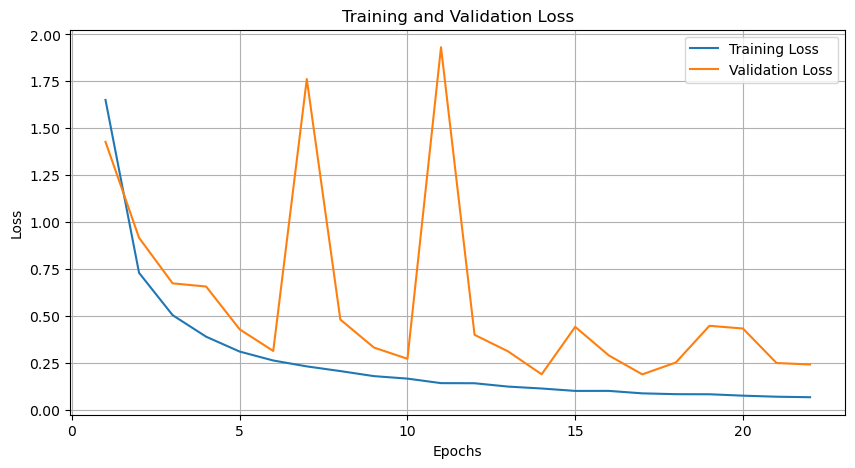

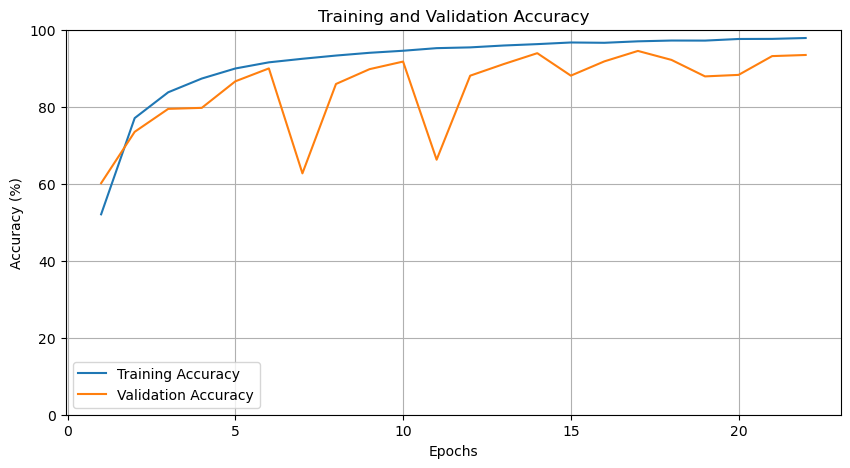

In [28]:
from utils import plot_training_history
plot_training_history(history)

# MobileNetV3 Large

In [7]:
mobilenetv3_large = models.mobilenet_v3_large(num_classes=num_classes)

In [9]:
from torchinfo import summary
summary(mobilenetv3_large, (64, 3, 64, 64))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [64, 39]                  --
├─Sequential: 1-1                                  [64, 960, 2, 2]           --
│    └─Conv2dNormActivation: 2-1                   [64, 16, 32, 32]          --
│    │    └─Conv2d: 3-1                            [64, 16, 32, 32]          432
│    │    └─BatchNorm2d: 3-2                       [64, 16, 32, 32]          32
│    │    └─Hardswish: 3-3                         [64, 16, 32, 32]          --
│    └─InvertedResidual: 2-2                       [64, 16, 32, 32]          --
│    │    └─Sequential: 3-4                        [64, 16, 32, 32]          464
│    └─InvertedResidual: 2-3                       [64, 24, 16, 16]          --
│    │    └─Sequential: 3-5                        [64, 24, 16, 16]          3,440
│    └─InvertedResidual: 2-4                       [64, 24, 16, 16]          --
│    │    └─Sequential: 3-6   

In [13]:
from ptflops import get_model_complexity_info

flops, params = get_model_complexity_info(mobilenetv3_large, (3, 64, 64), as_strings=True, print_per_layer_stat=True)
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")

MobileNetV3(
  4.25 M, 100.000% Params, 21.11 MMac, 98.864% MACs, 
  (features): Sequential(
    2.97 M, 69.896% Params, 19.82 MMac, 92.850% MACs, 
    (0): Conv2dNormActivation(
      464, 0.011% Params, 475.14 KMac, 2.226% MACs, 
      (0): Conv2d(432, 0.010% Params, 442.37 KMac, 2.072% MACs, 3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, 0.001% Params, 32.77 KMac, 0.153% MACs, 16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
    )
    (1): InvertedResidual(
      464, 0.011% Params, 491.52 KMac, 2.302% MACs, 
      (block): Sequential(
        464, 0.011% Params, 491.52 KMac, 2.302% MACs, 
        (0): Conv2dNormActivation(
          176, 0.004% Params, 196.61 KMac, 0.921% MACs, 
          (0): Conv2d(144, 0.003% Params, 147.46 KMac, 0.691% MACs, 16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenetv3_large.parameters(), lr=0.001)

In [13]:
from utils import plot_training_history, train_model
num_epochs = 100
history = train_model(mobilenetv3_large, train_loader, val_loader, num_epochs, criterion, optimizer, device='mps')

Epoch 1/100: 100%|██████████| 673/673 [02:04<00:00,  5.39batch/s]


Epoch [1/100], Train Loss: 1.5052, Train Accuracy: 56.02%, Val Loss: 1.0625, Val Accuracy: 67.22%
Checkpoint saved to checkpoints/best_model_epoch_1.pth


Epoch 2/100: 100%|██████████| 673/673 [01:56<00:00,  5.77batch/s]


Epoch [2/100], Train Loss: 0.6450, Train Accuracy: 79.53%, Val Loss: 1.8302, Val Accuracy: 57.14%


Epoch 3/100: 100%|██████████| 673/673 [01:54<00:00,  5.90batch/s]


Epoch [3/100], Train Loss: 0.4586, Train Accuracy: 85.26%, Val Loss: 1.4891, Val Accuracy: 65.56%


Epoch 4/100: 100%|██████████| 673/673 [01:55<00:00,  5.81batch/s]


Epoch [4/100], Train Loss: 0.3772, Train Accuracy: 87.89%, Val Loss: 0.7861, Val Accuracy: 77.87%
Checkpoint saved to checkpoints/best_model_epoch_4.pth


Epoch 5/100: 100%|██████████| 673/673 [01:59<00:00,  5.61batch/s]


Epoch [5/100], Train Loss: 0.3484, Train Accuracy: 88.92%, Val Loss: 0.5427, Val Accuracy: 84.24%
Checkpoint saved to checkpoints/best_model_epoch_5.pth


Epoch 6/100: 100%|██████████| 673/673 [02:01<00:00,  5.55batch/s]


Epoch [6/100], Train Loss: 0.2925, Train Accuracy: 90.64%, Val Loss: 1.5423, Val Accuracy: 67.24%


Epoch 7/100: 100%|██████████| 673/673 [02:03<00:00,  5.45batch/s]


Epoch [7/100], Train Loss: 0.2516, Train Accuracy: 91.79%, Val Loss: 0.4917, Val Accuracy: 86.40%
Checkpoint saved to checkpoints/best_model_epoch_7.pth


Epoch 8/100: 100%|██████████| 673/673 [02:04<00:00,  5.40batch/s]


Epoch [8/100], Train Loss: 0.2003, Train Accuracy: 93.51%, Val Loss: 0.2860, Val Accuracy: 91.45%
Checkpoint saved to checkpoints/best_model_epoch_8.pth


Epoch 9/100: 100%|██████████| 673/673 [01:56<00:00,  5.75batch/s]


Epoch [9/100], Train Loss: 0.1806, Train Accuracy: 94.15%, Val Loss: 1.0756, Val Accuracy: 74.35%


Epoch 10/100: 100%|██████████| 673/673 [01:58<00:00,  5.68batch/s]


Epoch [10/100], Train Loss: 0.1681, Train Accuracy: 94.59%, Val Loss: 2.0206, Val Accuracy: 60.18%


Epoch 11/100: 100%|██████████| 673/673 [02:05<00:00,  5.38batch/s]


Epoch [11/100], Train Loss: 0.1444, Train Accuracy: 95.20%, Val Loss: 0.2351, Val Accuracy: 93.26%
Checkpoint saved to checkpoints/best_model_epoch_11.pth


Epoch 12/100: 100%|██████████| 673/673 [02:08<00:00,  5.22batch/s]


Epoch [12/100], Train Loss: 0.1301, Train Accuracy: 95.78%, Val Loss: 0.3853, Val Accuracy: 89.42%


Epoch 13/100: 100%|██████████| 673/673 [02:05<00:00,  5.35batch/s]


Epoch [13/100], Train Loss: 0.1255, Train Accuracy: 95.92%, Val Loss: 0.3272, Val Accuracy: 91.42%


Epoch 14/100: 100%|██████████| 673/673 [02:05<00:00,  5.38batch/s]


Epoch [14/100], Train Loss: 0.1182, Train Accuracy: 96.21%, Val Loss: 0.2397, Val Accuracy: 93.72%


Epoch 15/100: 100%|██████████| 673/673 [02:13<00:00,  5.05batch/s]


Epoch [15/100], Train Loss: 0.1010, Train Accuracy: 96.68%, Val Loss: 0.2432, Val Accuracy: 93.46%


Epoch 16/100: 100%|██████████| 673/673 [02:13<00:00,  5.06batch/s]


Epoch [16/100], Train Loss: 0.1358, Train Accuracy: 95.71%, Val Loss: 0.5244, Val Accuracy: 87.30%
Early stopping triggered!
Training completed in: 36m 47s


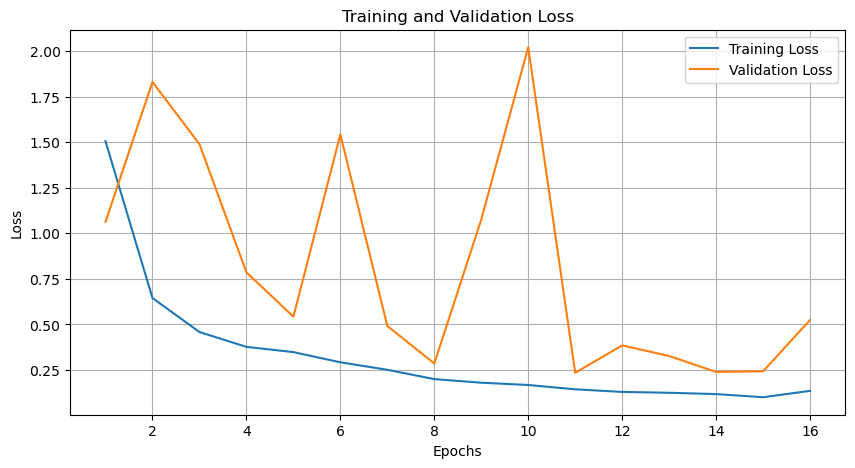

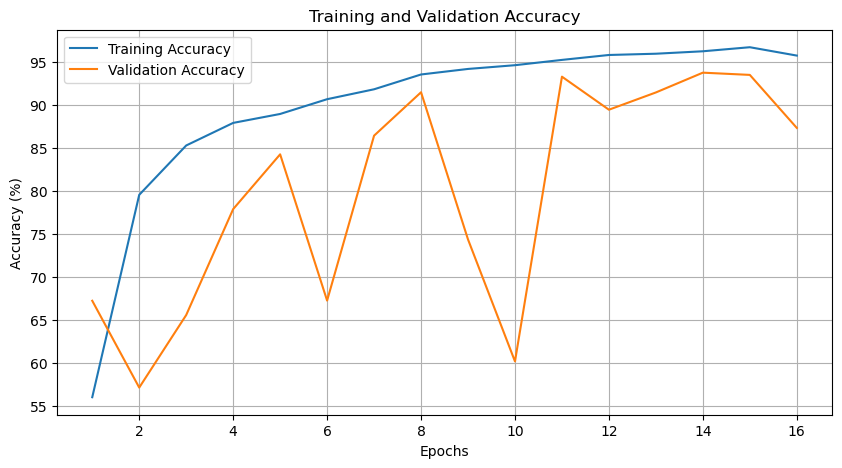

In [15]:
from utils import plot_training_history
plot_training_history(history)

# MobileNetV3 Small

In [10]:
mobilenetv3small = models.mobilenet_v3_small(num_classes=num_classes)

In [11]:
from torchinfo import summary

summary(mobilenetv3small, (64, 3, 64, 64))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [64, 39]                  --
├─Sequential: 1-1                                  [64, 576, 2, 2]           --
│    └─Conv2dNormActivation: 2-1                   [64, 16, 32, 32]          --
│    │    └─Conv2d: 3-1                            [64, 16, 32, 32]          432
│    │    └─BatchNorm2d: 3-2                       [64, 16, 32, 32]          32
│    │    └─Hardswish: 3-3                         [64, 16, 32, 32]          --
│    └─InvertedResidual: 2-2                       [64, 16, 16, 16]          --
│    │    └─Sequential: 3-4                        [64, 16, 16, 16]          744
│    └─InvertedResidual: 2-3                       [64, 24, 8, 8]            --
│    │    └─Sequential: 3-5                        [64, 24, 8, 8]            3,864
│    └─InvertedResidual: 2-4                       [64, 24, 8, 8]            --
│    │    └─Sequential: 3-6   

In [14]:
from ptflops import get_model_complexity_info

flops, params = get_model_complexity_info(mobilenetv3small, (3, 64, 64), as_strings=True, print_per_layer_stat=True)
print(f"FLOPs: {flops}")
print(f"Parameters: {params}")

MobileNetV3(
  1.56 M, 100.000% Params, 5.83 MMac, 98.905% MACs, 
  (features): Sequential(
    927.01 k, 59.506% Params, 5.2 MMac, 88.167% MACs, 
    (0): Conv2dNormActivation(
      464, 0.030% Params, 475.14 KMac, 8.058% MACs, 
      (0): Conv2d(432, 0.028% Params, 442.37 KMac, 7.503% MACs, 3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, 0.002% Params, 32.77 KMac, 0.556% MACs, 16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
    )
    (1): InvertedResidual(
      744, 0.048% Params, 127.26 KMac, 2.158% MACs, 
      (block): Sequential(
        744, 0.048% Params, 127.26 KMac, 2.158% MACs, 
        (0): Conv2dNormActivation(
          176, 0.011% Params, 49.15 KMac, 0.834% MACs, 
          (0): Conv2d(144, 0.009% Params, 36.86 KMac, 0.625% MACs, 16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(3

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenetv3small.parameters(), lr=0.001)

In [17]:
from utils import plot_training_history, train_model
num_epochs = 100
history = train_model(mobilenetv3small, train_loader, val_loader, num_epochs, criterion, optimizer, device="mps")

Epoch 1/100: 100%|██████████| 673/673 [01:42<00:00,  6.54batch/s]


Epoch [1/100], Train Loss: 1.5114, Train Accuracy: 55.96%, Val Loss: 1.6282, Val Accuracy: 53.34%
Checkpoint saved to checkpoints/best_model_epoch_1.pth


Epoch 2/100: 100%|██████████| 673/673 [01:36<00:00,  6.99batch/s]


Epoch [2/100], Train Loss: 0.6850, Train Accuracy: 78.24%, Val Loss: 0.7919, Val Accuracy: 75.68%
Checkpoint saved to checkpoints/best_model_epoch_2.pth


Epoch 3/100: 100%|██████████| 673/673 [01:36<00:00,  6.96batch/s]


Epoch [3/100], Train Loss: 0.4734, Train Accuracy: 84.69%, Val Loss: 0.6820, Val Accuracy: 79.28%
Checkpoint saved to checkpoints/best_model_epoch_3.pth


Epoch 4/100: 100%|██████████| 673/673 [01:36<00:00,  6.97batch/s]


Epoch [4/100], Train Loss: 0.3646, Train Accuracy: 88.08%, Val Loss: 0.5017, Val Accuracy: 84.45%
Checkpoint saved to checkpoints/best_model_epoch_4.pth


Epoch 5/100: 100%|██████████| 673/673 [01:35<00:00,  7.03batch/s]


Epoch [5/100], Train Loss: 0.2959, Train Accuracy: 90.34%, Val Loss: 0.4422, Val Accuracy: 86.52%
Checkpoint saved to checkpoints/best_model_epoch_5.pth


Epoch 6/100: 100%|██████████| 673/673 [01:35<00:00,  7.01batch/s]


Epoch [6/100], Train Loss: 0.2472, Train Accuracy: 91.92%, Val Loss: 2.1716, Val Accuracy: 58.19%


Epoch 7/100: 100%|██████████| 673/673 [01:35<00:00,  7.04batch/s]


Epoch [7/100], Train Loss: 0.2169, Train Accuracy: 92.80%, Val Loss: 0.3752, Val Accuracy: 88.81%
Checkpoint saved to checkpoints/best_model_epoch_7.pth


Epoch 8/100: 100%|██████████| 673/673 [01:35<00:00,  7.05batch/s]


Epoch [8/100], Train Loss: 0.1918, Train Accuracy: 93.70%, Val Loss: 0.4213, Val Accuracy: 87.27%


Epoch 9/100: 100%|██████████| 673/673 [01:35<00:00,  7.03batch/s]


Epoch [9/100], Train Loss: 0.1630, Train Accuracy: 94.63%, Val Loss: 0.6048, Val Accuracy: 83.23%


Epoch 10/100: 100%|██████████| 673/673 [01:35<00:00,  7.04batch/s]


Epoch [10/100], Train Loss: 0.1601, Train Accuracy: 94.68%, Val Loss: 1.1202, Val Accuracy: 73.85%


Epoch 11/100: 100%|██████████| 673/673 [01:35<00:00,  7.06batch/s]


Epoch [11/100], Train Loss: 0.1506, Train Accuracy: 95.01%, Val Loss: 0.4958, Val Accuracy: 86.23%


Epoch 12/100: 100%|██████████| 673/673 [01:36<00:00,  6.97batch/s]


Epoch [12/100], Train Loss: 0.1234, Train Accuracy: 95.93%, Val Loss: 0.8221, Val Accuracy: 80.21%
Early stopping triggered!
Training completed in: 21m 51s


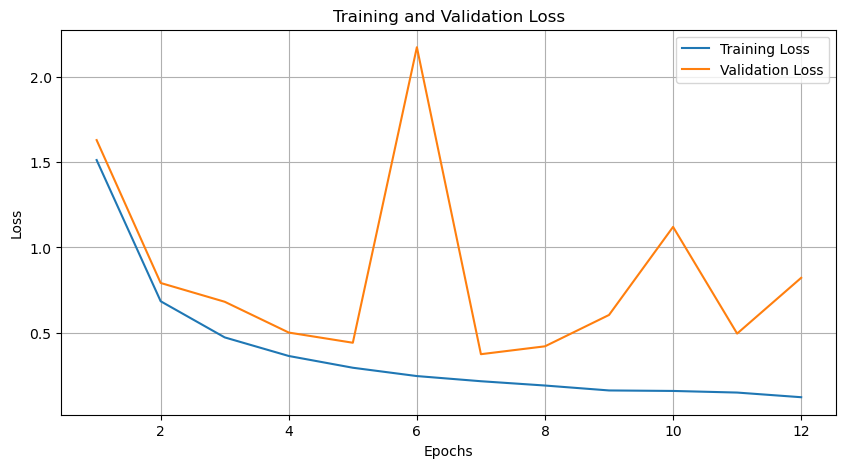

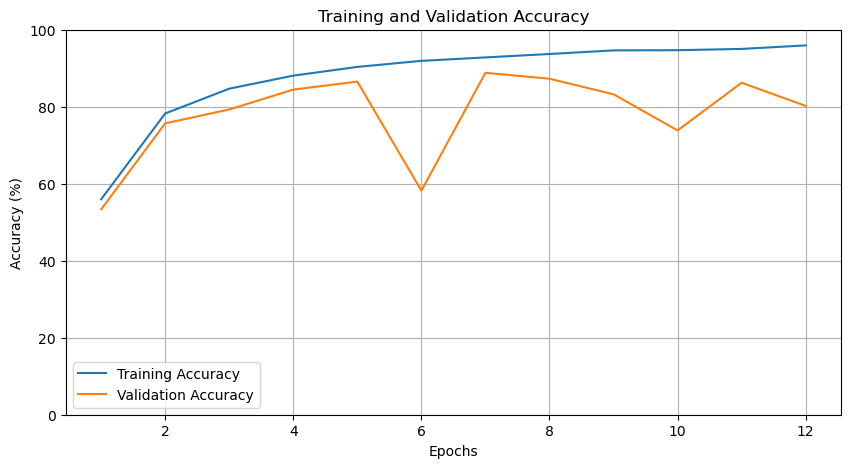

In [18]:
from utils import plot_training_history
plot_training_history(history)

# Evaluation

## MobileNetV2

In [30]:
loaded_mobilenetv2 = models.mobilenet_v2(num_classes=num_classes)
loaded_mobilenetv2.load_state_dict(torch.load(f='/Users/firmansyahsundana/Documents/tesis/checkpoints/64x64/mobilenetv2.pth', map_location="mps"))

<All keys matched successfully>

Final Loss: 12.5512


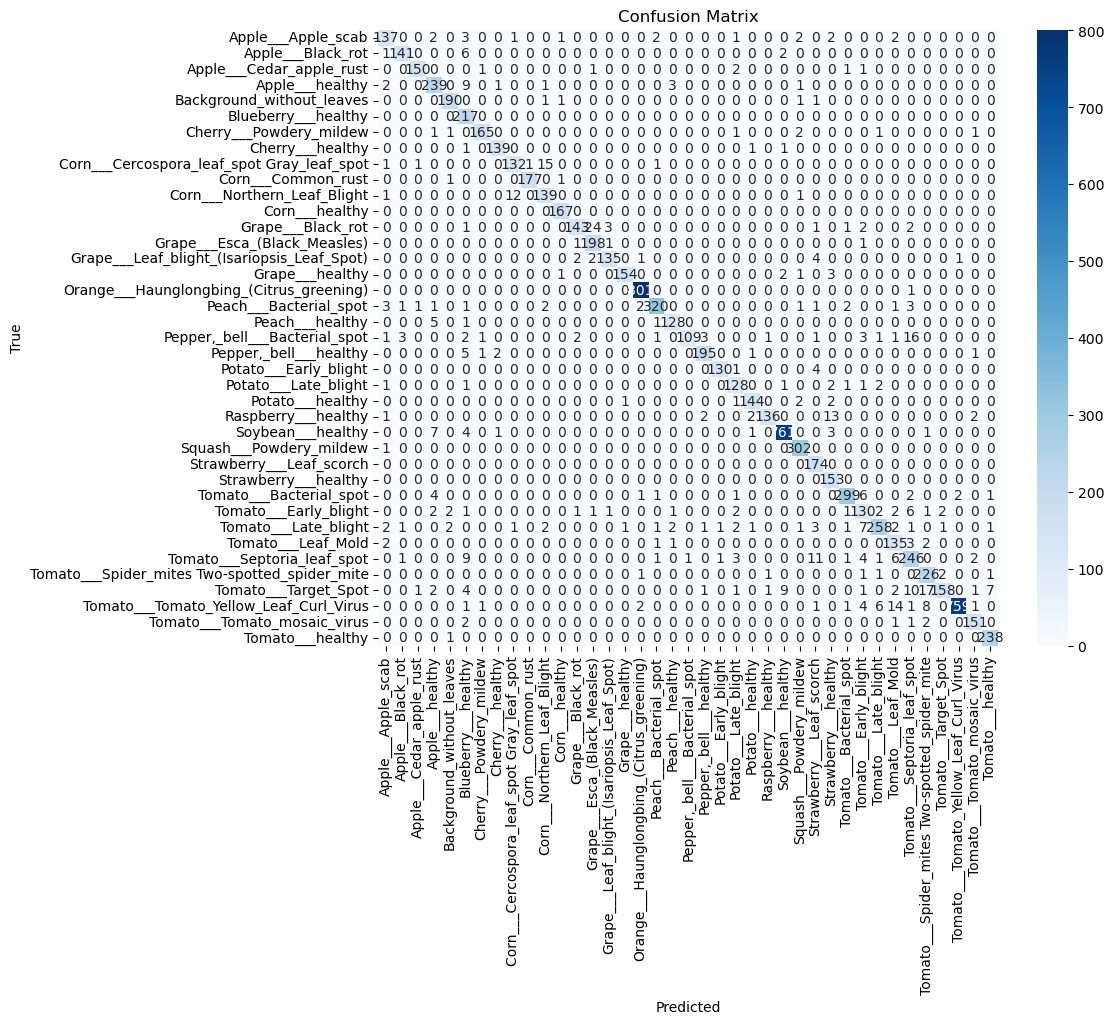

Accuracy: 0.94
Precision: 0.95
Recall: 0.94
F1 Score: 0.9434


In [31]:
from utils import evaluate_model

cm, performance_table, final_loss = evaluate_model(loaded_mobilenetv2, criterion, test_loader, class_names, device='mps')

In [32]:
from evaluations import measure_throughput_latency

avg_latency, throughput = measure_throughput_latency(loaded_mobilenetv2, test_loader, device='cpu')

print(f"Average Latency: {avg_latency:.4f} seconds per batch")
print(f"Throughput: {throughput:.2f} samples per second")

Average Latency: 0.6710 seconds per batch
Throughput: 94.81 samples per second


## MobileNetV3 Large

In [8]:
# Loaded model
loaded_mobilenetv3_large = models.mobilenet_v3_large(num_classes=num_classes)
loaded_mobilenetv3_large.load_state_dict(torch.load(f='/Users/firmansyahsundana/Documents/tesis/checkpoints/64x64/mobilenetv3_large.pth', map_location="mps"))

<All keys matched successfully>

Final Loss: 8.7232


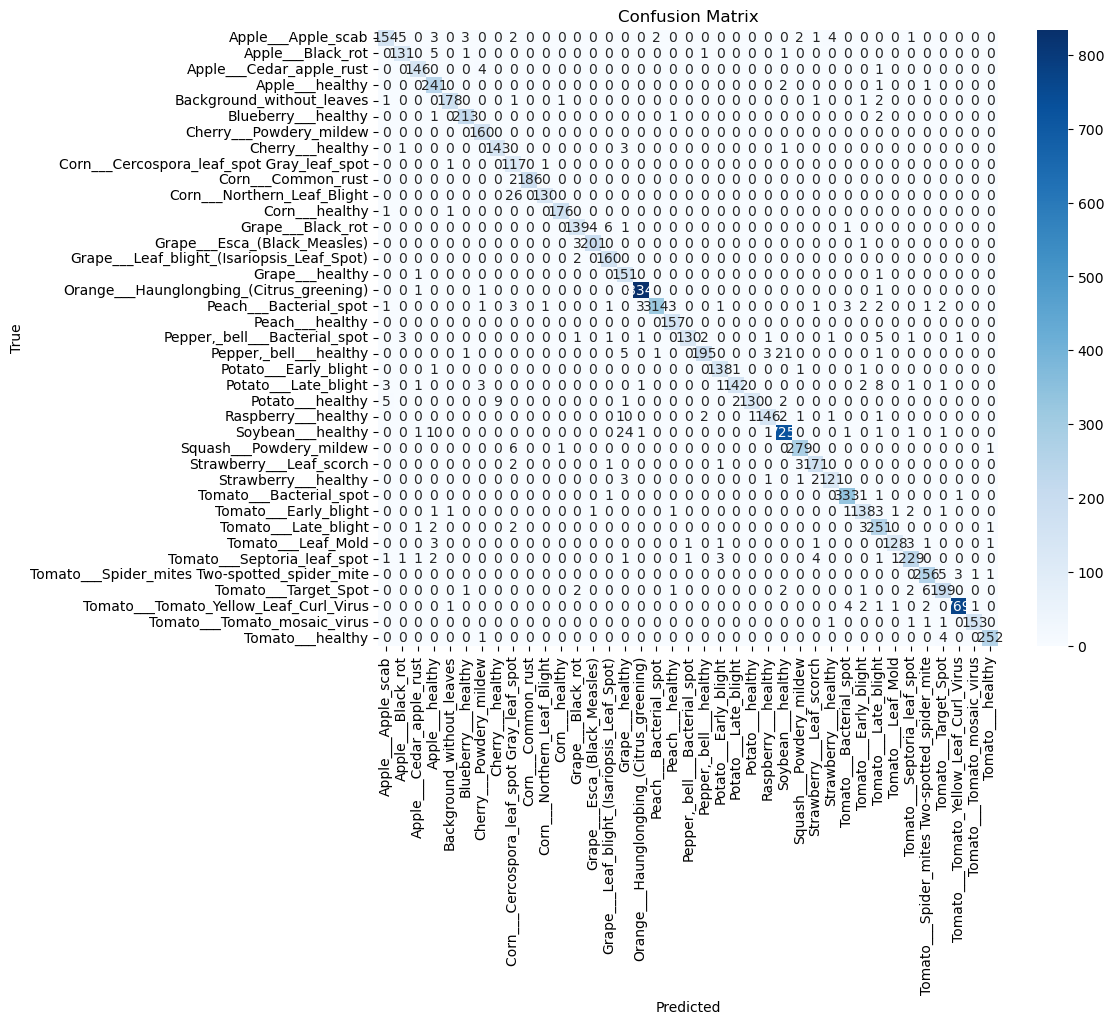

Accuracy: 0.96
Precision: 0.96
Recall: 0.96
F1 Score: 0.9561


In [27]:
from utils import evaluate_model

cm, performance_table, final_loss = evaluate_model(loaded_mobilenetv3_large, criterion, test_loader, class_names, device='mps')

In [9]:
from evaluations import measure_throughput_latency

avg_latency, throughput = measure_throughput_latency(loaded_mobilenetv3_large, test_loader, device='cpu')

print(f"Average Latency: {avg_latency:.4f} seconds per batch")
print(f"Throughput: {throughput:.2f} samples per second")

Average Latency: 0.8456 seconds per batch
Throughput: 75.23 samples per second


## MobileNetV3 Small

In [19]:

loaded_mobilenetv3_small = models.mobilenet_v3_small(num_classes=num_classes)
loaded_mobilenetv3_small.load_state_dict(torch.load(f='/Users/firmansyahsundana/Documents/tesis/checkpoints/64x64/mobilenetv3_small.pth', map_location="mps"))

<All keys matched successfully>

Final Loss: 23.0271


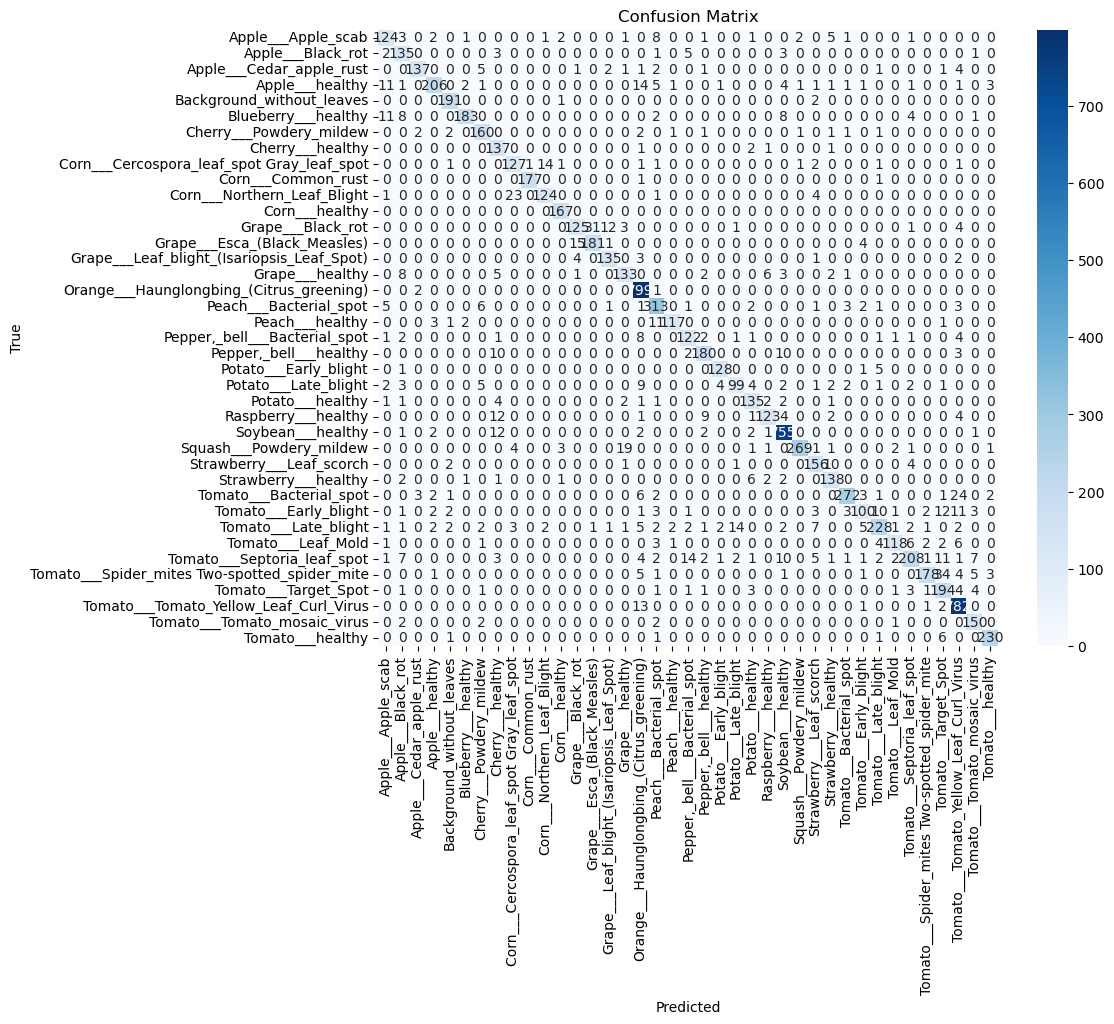

Accuracy: 0.89
Precision: 0.90
Recall: 0.89
F1 Score: 0.8917


In [20]:
from utils import evaluate_model

cm, performance_table, final_loss = evaluate_model(loaded_mobilenetv3_small, criterion, test_loader, class_names, device=device)

In [21]:
from evaluations import measure_throughput_latency

avg_latency, throughput = measure_throughput_latency(loaded_mobilenetv3_small, test_loader, device='cpu')

print(f"Average Latency: {avg_latency:.4f} seconds per batch")
print(f"Throughput: {throughput:.2f} samples per second")

Average Latency: 0.3997 seconds per batch
Throughput: 159.16 samples per second


# Result

## 64x64

In [36]:
import pandas as pd

mobilenetv2_result = {
    "model": "MobileNetV2",
    "accuracy": 0.94,
    "precision": 0.95,
    "recall": 0.94,
    "f1_score": 0.9434,
    "FLOPs (MMac)": 26.09,
    "Params (M)": 2.27,
    "training_time": "51m 46s",
    "throughput (sample/s)": 94.81,
    "average_latency (s/batch)": 0.6710,
    "size (m)": 570.50
}

mobilenetv3_large_result = {
    "model": "MobileNetV3 Large",
    "accuracy": 0.96,
    "precision": 0.96,
    "recall": 0.96,
    "f1_score": 0.9561,
    "FLOPs (MMac)": 21.35,
    "Params (M)": 4.25,
    "training_time": "36m 47s",
    "throughput (sample/s)": 75.23,
    "average_latency (s/batch)": 0.8456,
    "size (m)": 391.22
}

mobilenetv3_small_result = {
    "model": "MobileNetV3 Small",
    "accuracy": 0.89,
    "precision": 0.90,
    "recall": 0.89,
    "f1_score": 0.8917,
    "FLOPs (MMac)": 5.9,
    "Params (M)": 1.56,
    "training_time": "21m 51s",
    "throughput (sample/s)": 159.16,
    "average_latency (s/batch)": 0.3997,
    "size (m)": 129.50
}

In [37]:
result_table = pd.DataFrame([
    mobilenetv2_result,
    mobilenetv3_large_result,
    mobilenetv3_small_result
])
result_table

,model,accuracy,precision,recall,f1_score,FLOPs (MMac),Params (M),training_time,throughput (sample/s),average_latency (s/batch),size (m)
0,MobileNetV2,0.94,0.95,0.94,0.9434,26.09,2.27,51m 46s,94.81,0.6710,570.50
1,MobileNetV3 Large,0.96,0.96,0.96,0.9561,21.35,4.25,36m 47s,75.23,0.8456,391.22
2,MobileNetV3 Small,0.89,0.90,0.89,0.8917,5.90,1.56,21m 51s,159.16,0.3997,129.50
